In [1]:
import urllib
from KalshiClientsBase import ExchangeClient
import pandas as pd
import numpy as np
from datetime import datetime
import json
import urllib.request,urllib.parse,urllib.error
import matplotlib.pyplot as plt
import openpyxl

## Setting up

In [2]:
username = "" # change this 
password = "" # change this (for extra security, we recommend using a config file)
exchange_api_base = "https://trading-api.kalshi.com"

exchange_client = ExchangeClient(exchange_api_base, username, password)
print(exchange_client.user_id)
exchange_client.get_market_url('HOME-0001')

3301c8c8-6275-4727-b424-373bbb58f39e


'/v1/markets/HOME-0001'

## Get BBG forecasts

In [9]:
meetings = openpyxl.load_workbook("Rates data all fomc.xlsx").sheetnames # a list of all BBG sheet headings
dict_df = pd.read_excel('Rates data all fomc.xlsx', sheet_name=meetings)  # a dictionary of BBG dfs, keys = 'MMM-YY'
for key,df in dict_df.items():
    df.rename(columns={df.columns[1]: f"BBG-{key}" }, inplace = True)
    df.set_index('Date',inplace=True)

## Get Kalshi forecasts

In [10]:
markets = exchange_client.get_public_markets()
markets_df = pd.DataFrame(markets['markets']).set_index('id')
feds = markets_df[markets_df.title.str.contains("federal funds")]
#feds.iloc[14].ticker_name #All fed funds ticker is'FED-22MAR-T0.5' format

dict_keys(['MAR-22', 'MAY-22', 'JUN-22', 'JUL-22', 'SEP-22', 'NOV-22', 'DEC-22', 'FEB-23', 'MAR-23', 'MAY-23', 'JUN-23', 'JUL-23', 'SEP-23', 'NOV-23', 'DEC-23'])

## Helper functions

In [14]:
def get_contracts(year, month):
    #get range of contracts of different rates for that FOMC Meeting
    #e.g. year = 22, month = 'NOV'
    ranged_ticker = f'FED-{str(year)}{month}'
    target_contracts = markets_df[markets_df.ranged_group_ticker.str.contains(ranged_ticker)]
    columns = ['ranged_group_ticker','name','volume','yes_bid','yes_ask','list_date','close_date']
    targets = target_contracts[columns]
    return targets

def build_df(market_id, category):
    #function that returns daily closing price of that contract in a dataframe
    url = f'https://trading-api.kalshi.com/v1/cached/markets/{market_id}/stats_history'
    uh = urllib.request.urlopen(url)
    data= uh.read().decode()
    js = json.loads(data)
    
    df = pd.DataFrame(js['market_stats_points'])
    df['ts']= df['ts'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.drop('price',axis = 1)
    df['price'] = (df['yes_bid'] + df['yes_ask'])/2
    df = df.drop(['yes_bid','yes_ask'],axis = 1)
    
    #Get daily closing price with date column
    df['day'] = df['ts'].apply(lambda x: x.day)
    df['closing'] = np.where(df['day']!=df['day'].shift(-1),1,0)
    df.iloc[-1]['closing'] = 1
    df_target =df[df.closing ==1]
    df_target['Date']= df_target['ts'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df_target['Category'] = category
    
    return df_target

def build_df_each_rate(target_ids,target_bps):
    #Obtain a dictionary of dfs, each df contains daily info of that specific contract
    contracts = {}
    for market_id,bp in zip(target_ids,target_bps):
        contracts[bp] = build_df(market_id,bp)
    return contracts

def cumulative_df(contracts,month,year):
    #takes in dic of contracts, returns a df representing cumulative possibilities across time
    #Each row is a date, each column shows the price for the dif rates
    #month,year allows us to manually adjust for erroneous data
    
    final_df = pd.DataFrame({'Date': []})
    categories = list(contracts.keys())
    final_df['Date'] = contracts[categories[0]].Date
    for bp,df in contracts.items():
        final_df = pd.merge(final_df,df[['Date','price']],on = 'Date',how='left')
        final_df = final_df.rename(columns = {'price':bp} )
    #missing values are filled with 0 - unable to trade
    final_df = final_df.interpolate().fillna(0).set_index('Date').div(100)
    # #manually adjust for erroneous data
    if month == 'NOV' and year == 22:
        final_df.loc['2022-09-21','0.25%']=final_df.loc['2022-09-21','0.75%']  
        final_df.loc['2022-09-21','0.50%']=final_df.loc['2022-09-21','0.75%']  
    return final_df

def to_bps(string):
    return float(string.strip('%'))*100

def discrete_df(cumulative_df,month,year):
    #create new df for discrete rather than cumulative probabilities
    discrete_df = cumulative_df.copy()
    for ind, column in enumerate(cumulative_df.columns):
        if ind < len(cumulative_df.columns)-1:
            discrete_df[column] = cumulative_df[column] - cumulative_df.iloc[:,ind+1]
    rates=[]
    for rate in cumulative_df.columns:
        rates.append(to_bps(rate))

    def get_weighted(values):
        return np.average(a = rates,weights = values)

    #Calculate implied rates with weighted average
    discrete_df['Implied_rate'] = discrete_df.apply(get_weighted,axis = 1).round(2)
    kalshi_df = discrete_df['Implied_rate'].to_frame(name = f'Kalshi-{month}-{year}')
    #kalshi_df.reset_index(inplace=True)
    return kalshi_df

def combine_kalshi_bbg(month,year,kalshi_df,BBG_df):
    #BBG has more NA values: interpolate the weekends for BBG forecasts where Kalshi is still active
    #returns combined df where all units are in bps
    combined_df = kalshi_df.join(BBG_df).interpolate()
    combined_df.iloc[:,1:]=combined_df.iloc[:,1:]*100
    combined_df['Difference'] = combined_df.iloc[:,0] - combined_df.iloc[:,1]
    return combined_df

In [34]:
dic_combined_dfs={}
errors = [['NOV',22,'SEP'],['FEB',23,'SEP']]
monthdic = {'JAN':'01','FEB':'02','MAR':'03','APR':'04','MAY':'05','JUN':'06','JUL':'07','AUG':'08','SEP':'09','OCT':'10','NOV':'11','DEC':'12'}


for sheet_name in dict_df.keys():  #iterate over all meetings
    month,year = sheet_name.split('-') 
     #get ids for all relevant contracts for that meeting
    targets = get_contracts(year, month)
    # get dictionary of dataframe for specific contracts
    contracts = build_df_each_rate(target_ids = targets.index.tolist(), target_bps = targets.name.tolist()) 
    #get time series for cumulative probabilities over time
    cum_df = cumulative_df(contracts=contracts,month=month,year=year)
    
    #Look at erronerous data
    if month ==errors[0][0] and year == errors[0][1]:
        print(cum_df[f'20{year}-{monthdic[month]}-01':f'20{year}-{monthdic[month]}-28'])
    
    #convert into discrete probability densities and compute expectation
    kalshi_df = discrete_df(cum_df,month=month,year=year)
    #combined kalshi forecast with BBG forecast into 1 df
    BBG_df = dict_df[f'{month}-{year}']
    combined_df = combine_kalshi_bbg(month,year,kalshi_df=kalshi_df,BBG_df=BBG_df)
    
    #look only at dates after Feb 20th
    if sheet_name not in ['MAR-22','FEB-23']:
        combined_df = combined_df['2022-02-20':]
    #put that df into the dictionary
    dic_combined_dfs[sheet_name] = combined_df

<ipython-input-14-6e3dcb305583>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[-1]['closing'] = 1
<ipython-input-14-6e3dcb305583>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Date']= df_target['ts'].apply(lambda x: x.strftime("%Y-%m-%d"))
<ipython-input-14-6e3dcb305583>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [37]:
#Drop months not avaialble on Kalshi
keys = ['MAY-23', 'JUN-23', 'JUL-23','SEP-23','NOV-23','DEC-23']
list(map(dic_combined_dfs.pop, keys))
print(dic_combined_dfs.keys())

dict_keys(['MAR-22', 'MAY-22', 'JUN-22', 'JUL-22', 'SEP-22', 'NOV-22', 'DEC-22', 'FEB-23', 'MAR-23'])


## Checking Erroneous data

,Kalshi-NOV-22,BBG-NOV-22,Difference
Date,,,
2022-02-21,135.33,139.6,-4.27
2022-02-22,135.08,151.8,-16.72
2022-02-23,142.60,154.1,-11.50
2022-02-24,134.06,147.9,-13.84
2022-02-25,133.80,146.4,-12.60
...,...,...,...
2022-10-08,369.85,381.6,-11.75
2022-10-09,370.85,381.6,-10.75
2022-10-10,370.60,381.6,-11.00


## Plotting implied rates

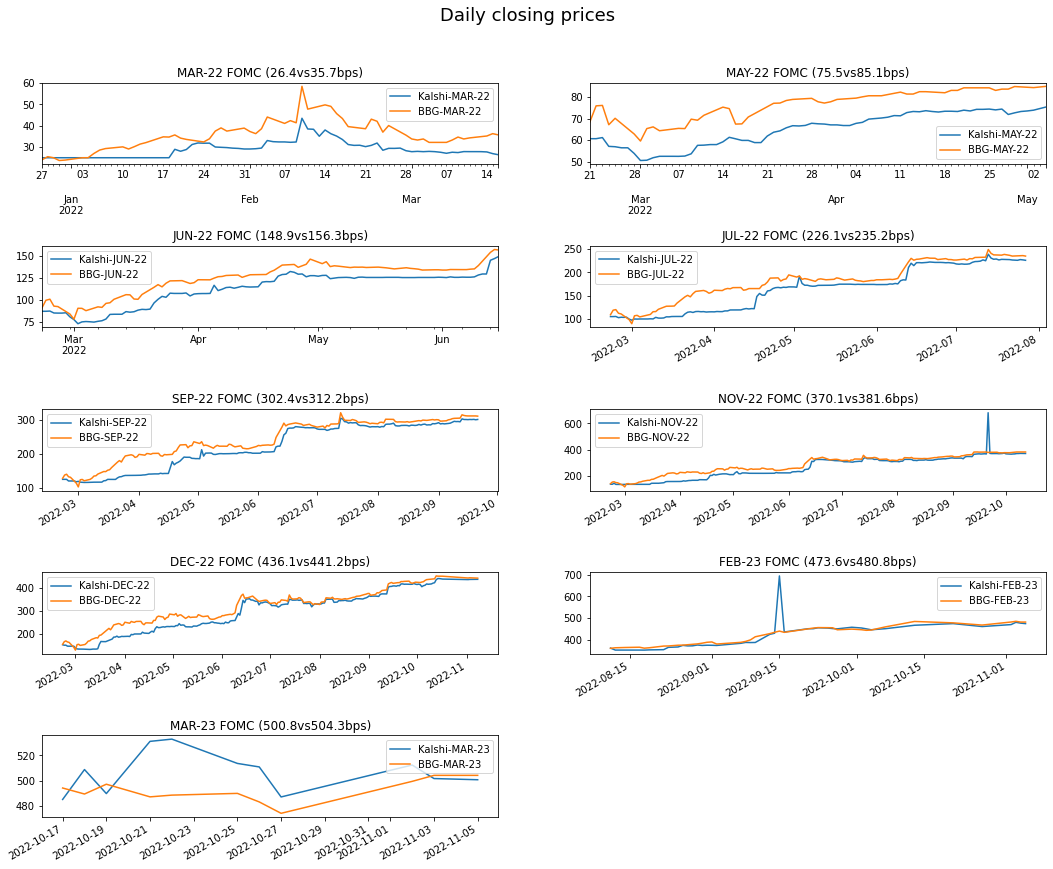

In [28]:
plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=1)
plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, meeting in enumerate(dic_combined_dfs.keys()):
    # add a new subplot iteratively
    ax = plt.subplot(5, 2, n + 1)
    # plot on the new subplot axis
    dic_combined_dfs[meeting].iloc[:,0:2].plot(ax=ax)
    # chart formatting
    kalshi_rate = dic_combined_dfs[meeting].iloc[-1,0].round(1)
    BBG_rate = dic_combined_dfs[meeting].iloc[-1,1].round(1)
    title = meeting+" FOMC " + f'({kalshi_rate}vs{BBG_rate}bps)'
    ax.set_title(title)
    ax.get_legend()
    ax.set_xlabel("")

## Plotting differences

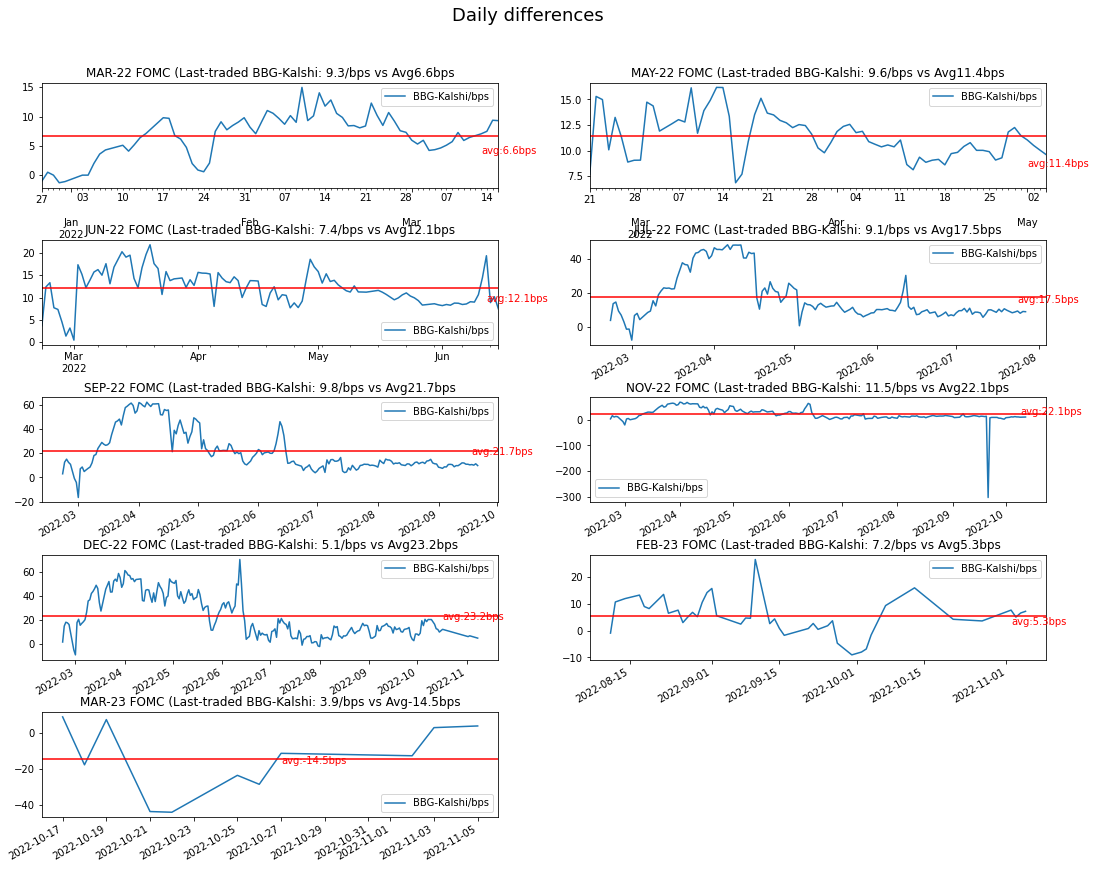

In [38]:
plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Daily differences", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, meeting in enumerate(dic_combined_dfs.keys()):
    # add a new subplot iteratively
    ax = plt.subplot(5, 2, n + 1)
    # plot on the new subplot axis
    (-dic_combined_dfs[meeting].iloc[:,2:]).plot(ax=ax)
    # chart formatting
    kalshi_rate = dic_combined_dfs[meeting].iloc[-1,0]
    BBG_rate = dic_combined_dfs[meeting].iloc[-1,1]
    average = -np.mean(dic_combined_dfs[meeting]['Difference'])
    title = meeting+" FOMC " + f'(Last-traded BBG-Kalshi: {(BBG_rate-kalshi_rate).round(1)}/bps vs Avg{round(average,1)}bps'
    plt.axhline(y = average, color = 'r', linestyle = '-')
    
    text_x = dic_combined_dfs[meeting].index[-4]
    text_y = average -3
    plt.text(x=text_x,y=text_y,s=f'avg:{round(average,1)}bps',color='r')
    ax.set_title(title)
    ax.get_legend()
    ax.legend(['BBG-Kalshi/bps'])
    ax.set_xlabel("")

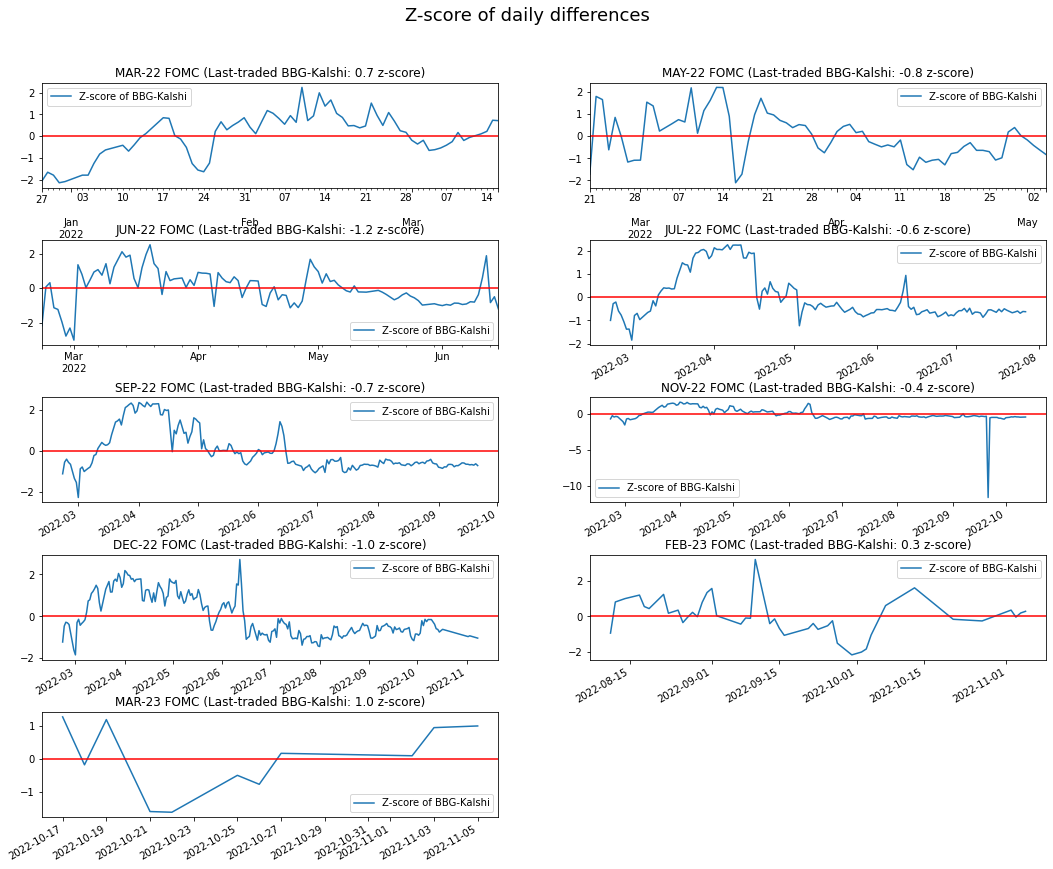

In [39]:
plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Z-score of daily differences", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, meeting in enumerate(dic_combined_dfs.keys()):
    # add a new subplot iteratively
    ax = plt.subplot(5, 2, n + 1)
    # plot on the new subplot axis
    average = -np.mean(dic_combined_dfs[meeting]['Difference'])
    std = np.std(dic_combined_dfs[meeting]['Difference'])
    (((-dic_combined_dfs[meeting].iloc[:,2:])-average)/std).plot(ax=ax)
    # chart formatting
    kalshi_rate = dic_combined_dfs[meeting].iloc[-1,0]
    BBG_rate = dic_combined_dfs[meeting].iloc[-1,1]
    title = meeting+" FOMC " + f'(Last-traded BBG-Kalshi: {round(((BBG_rate-kalshi_rate-average)/std),1)} z-score)'
    plt.axhline(y = 0, color = 'r', linestyle = '-')
    
#    text_x = dic_combined_dfs[meeting].index[-4]
#    text_y = average -3
#    plt.text(x=text_x,y=text_y,s=f'avg:{round(average,1)}bps',color='r')
    ax.set_title(title)
    ax.legend(['Z-score of BBG-Kalshi'])
    ax.set_xlabel("")

In [316]:
a.to_csv('NOV22 Kalshi.csv')  